<a href="https://colab.research.google.com/github/LuigiElo/DL-PINNs/blob/main/mainJacob.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Initial version

In [2]:
!pip install datasets
!pip install transformers
!pip install deepxde

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 521.2/521.2 kB 6.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 11.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 8.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.2/311.2 kB 25.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 47.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 89.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 58.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.2/166.2 kB 3.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.3/100.3 kB 11.5 MB/s eta 0:00:00


In [3]:
# Modules to be loaded and used
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"

import torch
from torch import nn
import math
from functools import partial
from pathlib import Path
from tqdm import tqdm
import rich
from typing import List, Tuple, Optional, Dict, Any
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import transformers
import tokenizers
import datasets
import zipfile
from huggingface_hub import hf_hub_download

from __future__ import division
from __future__ import print_function

import numpy as np
import deepxde as dde
from deepxde.backend import tf
from scipy.integrate import odeint
import re


from pylab import meshgrid,cm,imshow,contour,clabel,colorbar,axis,title,show

No backend selected.
Finding available backend...


Using backend: tensorflow.compat.v1
Other supported backends: tensorflow, pytorch, jax, paddle.
paddle supports more examples now and is recommended.
Instructions for updating:
non-resource variables are not supported in the long term


Found tensorflow.compat.v1
Setting the default backend to "tensorflow.compat.v1". You can change it in the ~/.deepxde/config.json file or export the DDE_BACKEND environment variable. Valid options are: tensorflow.compat.v1, tensorflow, pytorch, jax, paddle (all lowercase)


# (a) Function approximation
## 1D

Compiling model...
Building feed-forward neural network...
'build' took 0.092745 s

'compile' took 0.454101 s

Training model...

Step      Train loss    Test loss     Test metric   
0         [1.02e+00]    [6.22e-01]    [1.12e+00]    
1000      [3.91e-05]    [1.50e-01]    [5.50e-01]    
2000      [4.51e-06]    [1.92e-01]    [6.22e-01]    
3000      [1.41e-06]    [2.10e-01]    [6.51e-01]    
4000      [5.21e-07]    [2.24e-01]    [6.72e-01]    
5000      [2.76e-07]    [2.33e-01]    [6.86e-01]    
6000      [2.62e-06]    [2.39e-01]    [6.94e-01]    
7000      [1.47e-06]    [2.41e-01]    [6.97e-01]    
8000      [1.62e-07]    [2.41e-01]    [6.97e-01]    
9000      [1.35e-06]    [2.40e-01]    [6.96e-01]    
10000     [8.58e-05]    [2.38e-01]    [6.93e-01]    

Best model at step 8000:
  train loss: 1.62e-07
  test loss: 2.41e-01
  test metric: [6.97e-01]

'train' took 10.162848 s

Saving loss history to /content/loss.dat ...
Saving training data to /content/train.dat ...
Saving test data t

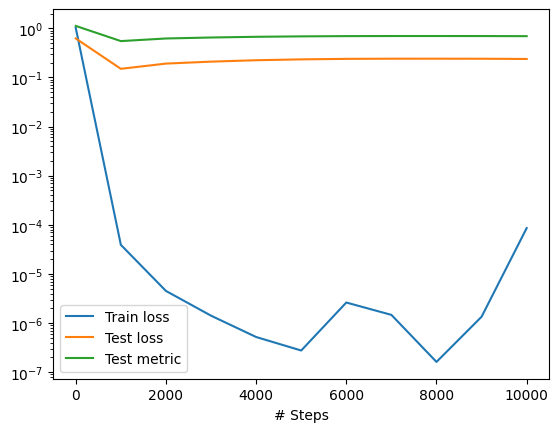

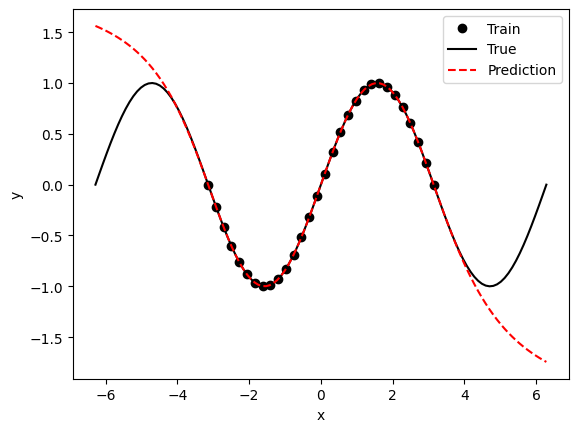

In [ ]:
n = 30
a = 1
b = 5
c = 1
N = np.pi
X  = np.linspace(-N,N,n)
#y  = a*X**3 + b*X**2 + c*X
y = np.sin(X)

Xtest = np.linspace(-2*N,2*N,4*n)
#ytest = a*Xtest**3 + b*Xtest**2 + c*Xtest
ytest = np.sin(Xtest)

# function approximation, test outside parameter domain
data1D = dde.data.DataSet(
    X_train=np.reshape(X, (-1, 1)),
    y_train=np.reshape(y, (-1, 1)),
    X_test=np.reshape(Xtest, (-1, 1)),
    y_test=np.reshape(ytest, (-1, 1)),
    col_x=(0,),
    col_y=(1,),
)

layer_size = [1] + 3*[20] + [1]
activation = "tanh"
initializer = "Glorot normal"
net = dde.maps.FNN(layer_size, activation, initializer)

model1 = dde.Model(data1D, net)
model1.compile("adam", lr = 0.001, metrics=["l2 relative error"])
losshistory, train_state = model1.train(epochs=10000)

dde.saveplot(losshistory, train_state, issave=True, isplot=True)


## 2D

Compiling model...
Building feed-forward neural network...
'build' took 0.129546 s

'compile' took 0.736849 s

Training model...

Step      Train loss    Test loss     Test metric   
0         [7.36e-01]    [7.96e-01]    [1.26e+00]    
1000      [2.92e-03]    [2.08e-01]    [6.45e-01]    
2000      [2.01e-04]    [5.68e-02]    [3.37e-01]    
3000      [5.70e-05]    [3.23e-02]    [2.54e-01]    
4000      [2.82e-05]    [2.54e-02]    [2.25e-01]    
5000      [1.82e-05]    [2.26e-02]    [2.13e-01]    

Best model at step 5000:
  train loss: 1.82e-05
  test loss: 2.26e-02
  test metric: [2.13e-01]

'train' took 11.290827 s

Saving loss history to /content/loss.dat ...
Saving training data to /content/train.dat ...
Saving test data to /content/test.dat ...


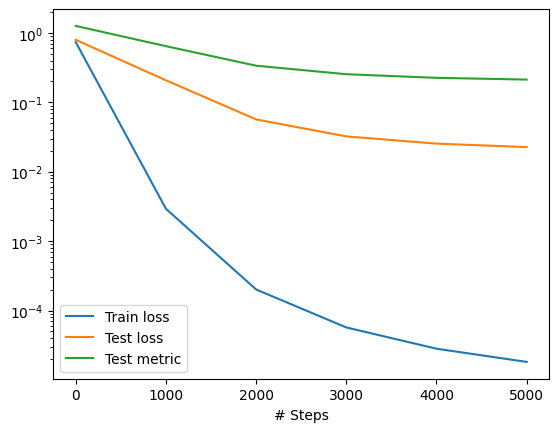

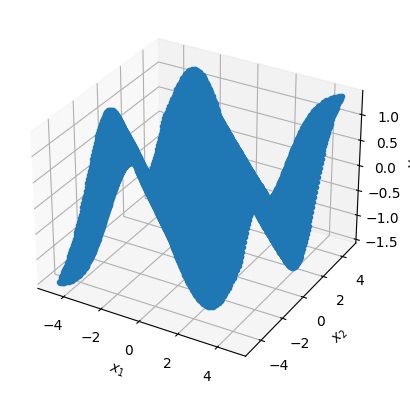

In [ ]:
n = 30
N = np.pi

# the function that I'm going to plot
def y_func(X1,X2):
 return np.sin(X1+X2)

x1 = np.linspace(-N,N,n)
x2 = x1

X1,X2 = meshgrid(x1, x2) # grid of point
y = y_func(X1, X2) # evaluation of the function on the grid

x1test = np.linspace(-1.5*N,1.5*N,4*n)
x2test = x1test

X1test,X2test = meshgrid(x1test, x2test) # grid of point
ytest = y_func(X1test, X2test) # evaluation of the function on the grid


# function approximation, test outside parameter domain
data2D = dde.data.DataSet(
    X_train = np.hstack(( np.reshape(X1, (-1, 1)),np.reshape(X2, (-1, 1)) )),
    y_train = np.reshape(y, (-1, 1)),
    X_test = np.hstack(( np.reshape(X1test, (-1, 1)),np.reshape(X2test, (-1, 1)) )),
    y_test = np.reshape(ytest, (-1, 1)),
    col_x = (0,),
    col_y = (1,),
)

layer_size = [2] + [20] * 3 + [1]
activation = "tanh"
initializer = "Glorot normal"
net = dde.maps.FNN(layer_size, activation, initializer)

model2 = dde.Model(data2D, net)
model2.compile("adam", lr = 0.001, metrics=["l2 relative error"])
losshistory, train_state = model2.train(epochs=5000)

dde.saveplot(losshistory, train_state, issave=True, isplot=True)


Compiling model...
Building feed-forward neural network...
'build' took 0.131760 s

'compile' took 0.904711 s

Training model...

Step      Train loss    Test loss     Test metric   
0         [7.10e+07]    [3.25e+08]    [1.00e+00]    
1000      [1.27e+06]    [3.00e+07]    [3.04e-01]    
2000      [2.82e+04]    [4.92e+06]    [1.23e-01]    
3000      [1.85e+04]    [4.14e+06]    [1.13e-01]    
4000      [1.44e+04]    [3.86e+06]    [1.09e-01]    
5000      [1.27e+04]    [3.70e+06]    [1.07e-01]    
6000      [1.02e+04]    [3.21e+06]    [9.93e-02]    
7000      [9.85e+03]    [3.32e+06]    [1.01e-01]    
8000      [7.95e+03]    [3.06e+06]    [9.69e-02]    
9000      [7.12e+03]    [3.06e+06]    [9.69e-02]    
10000     [7.30e+03]    [2.87e+06]    [9.38e-02]    
11000     [6.01e+03]    [2.94e+06]    [9.50e-02]    
12000     [5.81e+03]    [2.99e+06]    [9.58e-02]    
13000     [7.62e+03]    [3.13e+06]    [9.81e-02]    
14000     [4.80e+03]    [3.04e+06]    [9.66e-02]    
15000     [4.89e+03]  

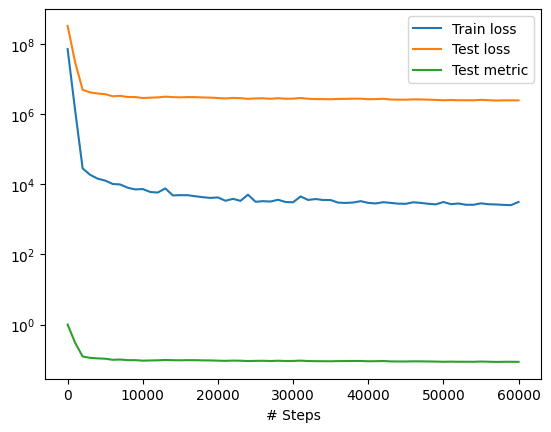

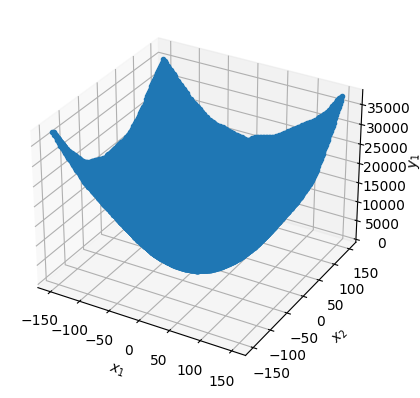

In [ ]:
# polynomial function in 2D

n = 30
N = 100

# the function that I'm going to plot
def y_func(X1,X2):
 return X1**2 + X2**2

x1 = np.linspace(-N,N,n)
x2 = x1

X1,X2 = meshgrid(x1, x2) # grid of point
y = y_func(X1, X2) # evaluation of the function on the grid

x1test = np.linspace(-1.5*N,1.5*N,4*n)
x2test = x1test

X1test,X2test = meshgrid(x1test, x2test) # grid of point

ytest = y_func(X1test, X2test) # evaluation of the function on the grid


# function approximation, test outside parameter domain
data2D = dde.data.DataSet(
    X_train = np.hstack(( np.reshape(X1, (-1, 1)),np.reshape(X2, (-1, 1)) )),
    y_train = np.reshape(y, (-1, 1)),
    X_test = np.hstack(( np.reshape(X1test, (-1, 1)),np.reshape(X2test, (-1, 1)) )),
    y_test = np.reshape(ytest, (-1, 1)),
    col_x = (0,),
    col_y = (1,),
)

layer_size = [2] + 3*[20] + [1]
activation = "relu"
initializer = "Glorot normal"
net = dde.maps.FNN(layer_size, activation, initializer)

model1 = dde.Model(data2D, net)
model1.compile("adam", lr = 0.005, metrics=["l2 relative error"])
losshistory, train_state = model1.train(epochs=60000)

dde.saveplot(losshistory, train_state, issave=True, isplot=True)

# (b)

## 1D

In [ ]:
# compute gradient of solution
def dudx(x, u):
  return dde.grad.jacobian(u, x, i=0)

du_dx = model1.predict(np.reshape(X, (-1, 1)), operator=dudx)

yx = np.cos(np.reshape(X, (-1, 1)))

plt.figure()
plt.plot(X,yx,'k',label='True')
plt.plot(np.reshape(X, (-1, 1)),du_dx,'r',label='Predicted')
plt.xlabel('x')
plt.ylabel('du/dx')
plt.legend()
plt.show()

plt.figure()
plt.plot(X,du_dx-np.reshape(yx,(-1,1)),'r')
plt.xlabel('x')
plt.ylabel('Error')
plt.show()

ValueError: ignored

##2D

(900, 1) (900, 1) (900, 1) (900, 1)


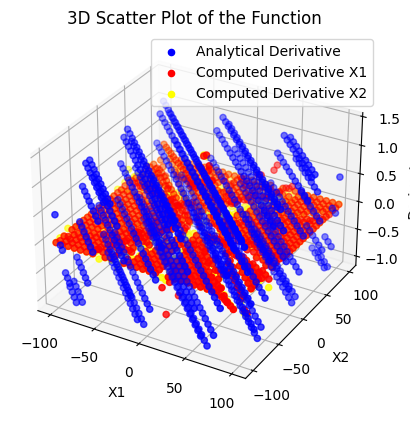

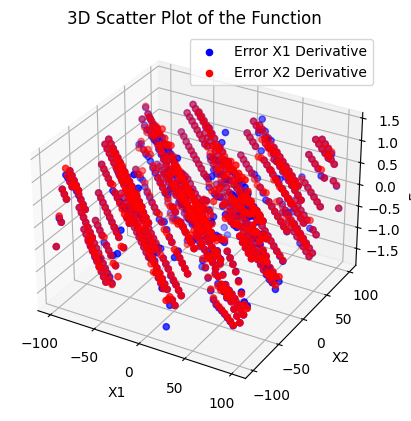

In [ ]:
# compute gradient of solution
def dudx(x, u):
  return dde.grad.jacobian(u, x, i=0)

du_dx1 = model2.predict(np.hstack(( np.reshape(X1, (-1, 1)),np.reshape(X2, (-1, 1)) )) , operator=dudx)

#du_dx1[:,0] and du_dx[:,1] are the computed derivatives for each variable in each point belonging to X

#the analytical derivate for both variables is exactly the same
yx = np.cos(np.reshape(X1, (-1, 1))+np.reshape(X2, (-1, 1)))

du_dx10=du_dx1[:,0]
du_dx10 = du_dx10.reshape(-1, 1)

du_dx11=du_dx1[:,1]
du_dx11 = du_dx11.reshape(-1, 1)
#yx = yx.reshape(-1, 1)

print(np.shape(du_dx10),np.shape(yx),np.shape(np.reshape(X1, (-1, 1))),np.shape(np.reshape(X2, (-1, 1))))

loss0=du_dx10-yx
loss1=du_dx11-yx

# Create a 3D scatter plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(np.reshape(X1, (-1, 1)),np.reshape(X2, (-1, 1)), yx, marker='o', label='Analytical Derivative', color='blue')
ax.scatter(np.reshape(X1, (-1, 1)),np.reshape(X2, (-1, 1)), du_dx10, marker='o', label='Computed Derivative X1', color='red')
ax.scatter(np.reshape(X1, (-1, 1)),np.reshape(X2, (-1, 1)), du_dx11, marker='o', label='Computed Derivative X2', color='yellow')

ax.set_xlabel('X1')
ax.set_ylabel('X2')
ax.set_zlabel('Derivative')
plt.title('3D Scatter Plot of the Function')
plt.legend()
plt.show()

# Create a 3D scatter plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(np.reshape(X1, (-1, 1)),np.reshape(X2, (-1, 1)), loss0, marker='o', label='Error X1 Derivative', color='blue')
ax.scatter(np.reshape(X1, (-1, 1)),np.reshape(X2, (-1, 1)), loss1, marker='o', label='Error X2 Derivative', color='red')

ax.set_xlabel('X1')
ax.set_ylabel('X2')
ax.set_zlabel('Error')
plt.title('3D Scatter Plot of the Function')
plt.legend()
plt.show()

# (c)

## 1D

Compiling model...
Building feed-forward neural network...
'build' took 0.064936 s

'compile' took 0.354070 s

Training model...

Step      Train loss    Test loss     Test metric   
0         [6.20e-01]    [5.47e-01]    [1.05e+00]    
1000      [3.59e-04]    [6.38e-01]    [1.13e+00]    
2000      [9.57e-05]    [6.05e-01]    [1.10e+00]    
3000      [5.60e-05]    [5.87e-01]    [1.08e+00]    
4000      [3.59e-05]    [5.50e-01]    [1.05e+00]    
5000      [1.60e-05]    [5.07e-01]    [1.01e+00]    

Best model at step 5000:
  train loss: 1.60e-05
  test loss: 5.07e-01
  test metric: [1.01e+00]

'train' took 8.062288 s

Saving loss history to /content/loss.dat ...
Saving training data to /content/train.dat ...
Saving test data to /content/test.dat ...


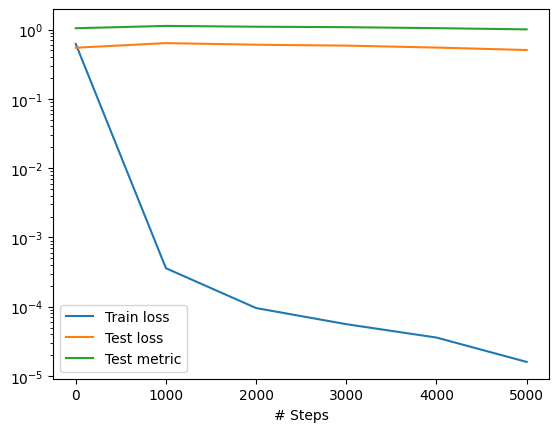

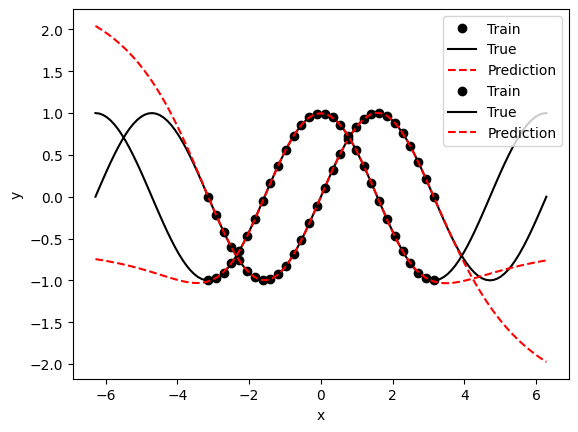

In [ ]:
n = 30
X  = np.linspace(-np.pi,np.pi,n)
y  = [np.sin(X),np.cos(X)]

Xtest  = np.linspace(-2*np.pi,2*np.pi,4*n)
ytest  = [np.sin(Xtest),np.cos(Xtest)]

# reshaping output training data
y1 = np.asmatrix(y[0]).transpose()
y2 = np.asmatrix(y[1]).transpose()
ynew = np.concatenate((y1,y2),axis=1)
ynew = np.asarray(ynew)

# reshaping output test data
ytest1 = np.asmatrix(ytest[0]).transpose()
ytest2 = np.asmatrix(ytest[1]).transpose()
ytestnew = np.concatenate((ytest1,ytest2),axis=1)
ytestnew = np.asarray(ytestnew)


# function approximation, test outside parameter domain
data1Dg = dde.data.DataSet(
    X_train=np.reshape(X, (-1, 1)),
    y_train=ynew,
    X_test=np.reshape(Xtest, (-1, 1)),
    y_test=ytestnew,
    col_x=(0,),
    col_y=(1,),
)

layer_size = [1] + [20] * 3 + [2]
activation = "tanh"
initializer = "Glorot normal"
net = dde.maps.FNN(layer_size, activation, initializer)

model = dde.Model(data1Dg, net)
model.compile("adam", lr = 0.001, metrics=["l2 relative error"])
losshistory, train_state = model.train(epochs=5000)

dde.saveplot(losshistory, train_state, issave=True, isplot=True)

## 2D

Compiling model...
Building feed-forward neural network...
'build' took 0.058061 s

'compile' took 0.369752 s

Training model...

Step      Train loss    Test loss     Test metric   
0         [1.02e+00]    [1.13e+00]    [1.51e+00]    
1000      [4.20e-03]    [5.53e-01]    [1.05e+00]    
2000      [5.77e-04]    [4.63e-01]    [9.63e-01]    
3000      [1.90e-04]    [4.10e-01]    [9.06e-01]    
4000      [9.03e-05]    [3.79e-01]    [8.71e-01]    
5000      [4.30e-05]    [3.60e-01]    [8.49e-01]    

Best model at step 5000:
  train loss: 4.30e-05
  test loss: 3.60e-01
  test metric: [8.49e-01]

'train' took 7.419063 s

Saving loss history to /content/loss.dat ...
Saving training data to /content/train.dat ...
Saving test data to /content/test.dat ...


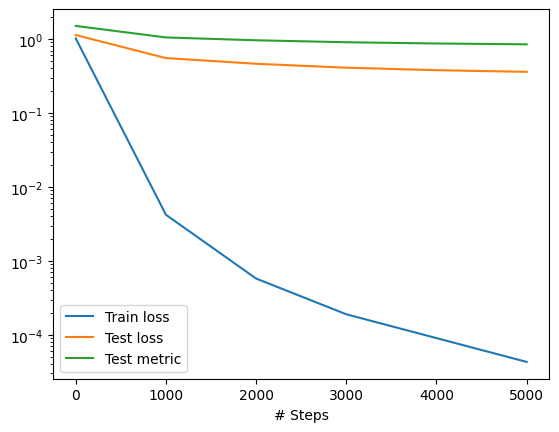

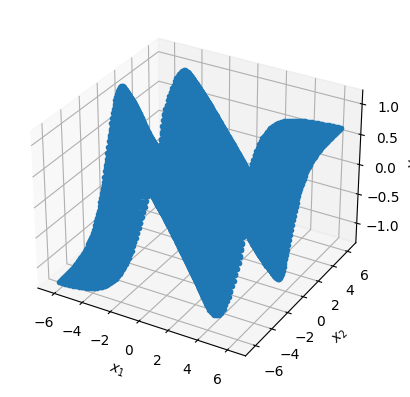

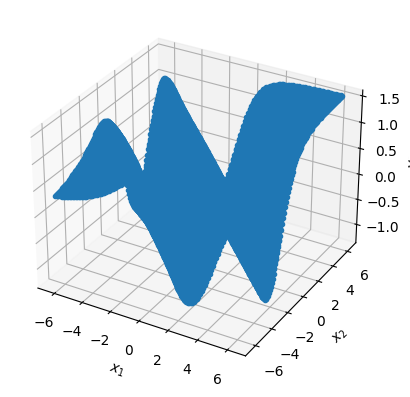

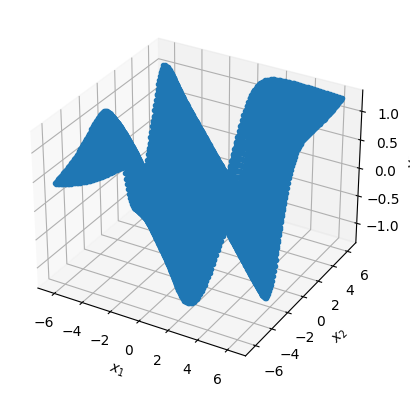

In [ ]:
n = 30
N = np.pi

# the function that I'm going to plot
def y_func(X1,X2):
 return np.sin(X1+X2)

def y_grad(X1,X2):
 return np.cos(X1+X2),np.cos(X1+X2)

x1 = np.linspace(-N,N,n)
x2 = x1

X1,X2 = meshgrid(x1, x2) # grid of points
y = y_func(X1, X2) # evaluation of the function on the grid
yg = y_grad(X1,X2) # evaluation of the gradient on the grid

# Collecting and reshaping training function val and gradient val into one output:
y = np.hstack((np.reshape(y, (-1, 1)), np.reshape(yg[0], (-1, 1)), np.reshape(yg[1], (-1, 1)) ))


x1test = np.linspace(-2*N,2*N,4*n)
x2test = x1test

X1test,X2test = meshgrid(x1test, x2test) # grid of point
ytest = y_func(X1test, X2test) # evaluation of the function on the grid
ytestg = y_grad(X1test,X2test) # evaluation of the gradient on the grid

# Collecting and reshaping testing output function val and gradient val into one output:
ytest = np.hstack((np.reshape(ytest, (-1, 1)), np.reshape(ytestg[0], (-1, 1)), np.reshape(ytestg[1], (-1, 1)) ))




# function approximation, test outside parameter domain
data2Dg = dde.data.DataSet(
    X_train = np.hstack(( np.reshape(X1, (-1, 1)),np.reshape(X2, (-1, 1)) )),
    y_train = y,
    X_test = np.hstack(( np.reshape(X1test, (-1, 1)),np.reshape(X2test, (-1, 1)) )),
    y_test = ytest,
    col_x = (0,),
    col_y = (1,),
)

layer_size = [2] + [20] * 3 + [3]
activation = "tanh"
initializer = "Glorot normal"
net = dde.maps.FNN(layer_size, activation, initializer)

model = dde.Model(data2Dg, net)
model.compile("adam", lr = 0.001, metrics=["l2 relative error"])
losshistory, train_state = model.train(epochs=5000)

dde.saveplot(losshistory, train_state, issave=True, isplot=True)

##d)

##1D

In [ ]:
def test_dataset1D():
  n=30
  N = np.pi
  X  = np.linspace(-2*N,2*N,n)
  #y  = a*X**3 + b*X**2 + c*X
  y = np.sin(X)
  return X,y

In [ ]:
import time

def create_model1D(n_data_train,n_layers,n_neurons):
  a = 1
  b = 5
  c = 1
  N = np.pi
  X  = np.linspace(-N,N,n_data_train)
  #y  = a*X**3 + b*X**2 + c*X
  y = np.sin(X)

  Xtest = np.linspace(N,3*N,n)
  #ytest = a*Xtest**3 + b*Xtest**2 + c*Xtest
  ytest = np.sin(Xtest)

  # function approximation, test outside parameter domain
  data1D = dde.data.DataSet(
      X_train=np.reshape(X, (-1, 1)),
      y_train=np.reshape(y, (-1, 1)),
      X_test=np.reshape(Xtest, (-1, 1)),
      y_test=np.reshape(ytest, (-1, 1)),
      col_x=(0,),
      col_y=(1,),
  )

  layer_size = [1] + n_layers*[n_neurons] + [1]
  activation = "tanh"
  initializer = "Glorot normal"
  net = dde.maps.FNN(layer_size, activation, initializer)

  model1 = dde.Model(data1D, net)
  model1.compile("adam", lr = 0.001, metrics=["l2 relative error"])
  start_time = time.time()
  losshistory, train_state = model1.train(epochs=10000)
  end_time = time.time()
  #dde.saveplot(losshistory, train_state, issave=True, isplot=True)

  return model1,(end_time-start_time)

In [ ]:
# the accuracy will be studied in 4 possible scenarios: 1 layer, 20 units | 1 layer 32 units | 2 layers, 20 units | 2 layers 32 units

X,Y= test_dataset1D() #test dataset generated
Y=np.reshape(Y, (-1, 1))

losses_models=[]
n_values=[]
param_config= [[1,20],[1,32],[2,20],[2,32]] #possible parameters configurations
#each iteration in the loop will have different dataset size with steps of 5. We will start from n=10 till n=100
for n in range(5, 101, 5):
  losses_configs=[]
  for conf in param_config:
    print(conf)
    #n=20
    model,_= create_model1D(n,conf[0],conf[1]) # training set size = n, number of hidden layers= 1, number of hidden units per layer=20
    print()
    #print(X,Y)
    pred=model.predict(np.reshape(X, (-1, 1)))
    loss=pred-Y
    losses_configs.append(abs(np.mean(loss)))

  n_values.append(n)
  losses_models.append(losses_configs)
  print(f"Loss calculated for model feeded with dataset size {n}...")

[1, 20]
Compiling model...
Building feed-forward neural network...
'build' took 0.035984 s

'compile' took 0.315360 s

Training model...

Step      Train loss    Test loss     Test metric   
0         [9.52e-01]    [5.14e-01]    [1.13e+00]    
1000      [4.11e-03]    [2.10e+00]    [2.29e+00]    
2000      [1.18e-11]    [2.12e+00]    [2.30e+00]    
3000      [4.91e-09]    [2.12e+00]    [2.30e+00]    
4000      [1.67e-14]    [2.12e+00]    [2.30e+00]    
5000      [4.54e-12]    [2.12e+00]    [2.30e+00]    
6000      [9.73e-13]    [2.12e+00]    [2.30e+00]    
7000      [4.24e-12]    [2.12e+00]    [2.30e+00]    
8000      [3.70e-10]    [2.12e+00]    [2.30e+00]    
9000      [8.29e-08]    [2.12e+00]    [2.30e+00]    
10000     [1.16e-11]    [2.12e+00]    [2.30e+00]    

Best model at step 4000:
  train loss: 1.67e-14
  test loss: 2.12e+00
  test metric: [2.30e+00]

'train' took 7.105681 s


[1, 32]
Compiling model...
Building feed-forward neural network...
'build' took 0.046651 s

'compile' 

KeyboardInterrupt: ignored

In [ ]:
print(np.shape(losses_models))

loss_final1=[]
loss_final2=[]
loss_final3=[]
loss_final4=[]
for el in range(np.shape(losses_models)[0]): #20
  loss_final1.append(losses_models[el][0])
  loss_final2.append(losses_models[el][1])
  loss_final3.append(losses_models[el][2])
  loss_final4.append(losses_models[el][3])

print(loss_final1)

In [ ]:
# Create a plot of accuracy vs. `n`
plt.figure()
plt.plot(n_values, loss_final1, marker='o', linestyle='-', color='b', label= '20 parameters (1 layer)')
plt.plot(n_values, loss_final2, marker='o', linestyle='-', color='r', label= '32 parameters (1 layer)')
plt.plot(n_values, loss_final3 , marker='o', linestyle='-', color='g', label= '40 parameters (2 layers)')
plt.plot(n_values, loss_final4 , marker='o', linestyle='-', color='y', label= '64 parameters (2 layers)')
plt.title('Loss vs. Number of Training Data Points ')
plt.xlabel('Number of Data Points (n)')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()
plt.show()



##e)

In [ ]:
#we will study the training time

param_config= [[1,20],[1,32],[2,20],[1,48],[2,32],[2,48]] #possible parameters configurations
X,Y= test_dataset1D() #test dataset generated

train_times=[]
test_times=[]
n_parameters=[]

for conf in param_config:
  model,train_time= create_model1D(50,conf[0],conf[1])
  start_time= time.time()
  pred=model.predict(np.reshape(X, (-1, 1)))
  end_time= time.time()
  train_times.append(train_time)
  test_times.append(end_time-start_time)
  n_parameters.append(conf[0]*conf[1])



In [ ]:
print(n_parameters)
print(train_times)

In [ ]:
# Create a plot of training time vs. number of parameters
plt.figure()
plt.plot(n_parameters, train_times , marker='o', linestyle='-', color='b')
plt.title('Training time vs. Number of parameters ')
plt.xlabel('Number of parameters')
plt.ylabel('Training time')
plt.grid(True)
plt.show()

# Create a plot of inference time vs. number of parameters
plt.figure()
plt.plot(n_parameters, test_times , marker='o', linestyle='-', color='b')
plt.title('Test time vs. Number of parameters ')
plt.xlabel('Number of parameters')
plt.ylabel('Test time')
plt.grid(True)
plt.show()

# (f)

Compiling model...
Building feed-forward neural network...
'build' took 0.127433 s

'compile' took 2.676723 s

Training model...

Step      Train loss              Test loss               Test metric   
0         [4.09e+01, 1.02e-02]    [4.92e+01, 1.02e-02]    [9.91e-01]    
1000      [3.23e-03, 8.72e-05]    [1.42e+00, 8.72e-05]    [5.07e-01]    
2000      [2.77e-01, 5.86e-02]    [6.11e-01, 5.86e-02]    [2.78e-01]    
3000      [5.68e-03, 2.17e-04]    [5.64e-01, 2.17e-04]    [2.07e-01]    
4000      [1.64e-03, 2.88e-04]    [5.97e-01, 2.88e-04]    [2.36e-01]    
5000      [2.47e-11, 1.32e-12]    [1.24e-01, 1.32e-12]    [4.36e-02]    
6000      [7.76e-03, 2.63e-04]    [1.05e-01, 2.63e-04]    [3.65e-02]    
7000      [4.70e-04, 5.74e-05]    [9.32e-02, 5.74e-05]    [4.02e-02]    
8000      [8.79e-10, 5.91e-11]    [1.26e-01, 5.91e-11]    [5.76e-02]    
9000      [4.57e-02, 1.55e-03]    [1.64e-01, 1.55e-03]    [4.39e-02]    
10000     [2.04e-11, 3.70e-13]    [1.49e-01, 3.70e-13]    [6.25e-02

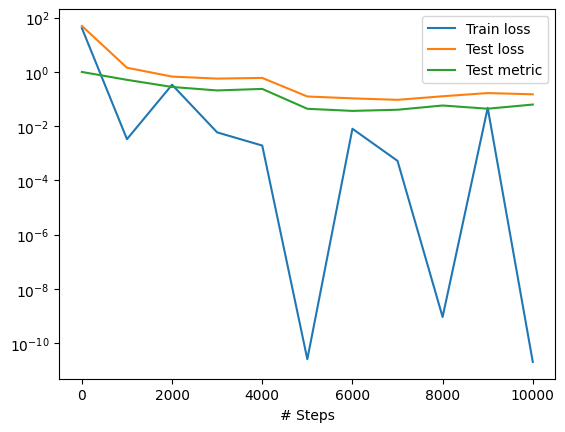

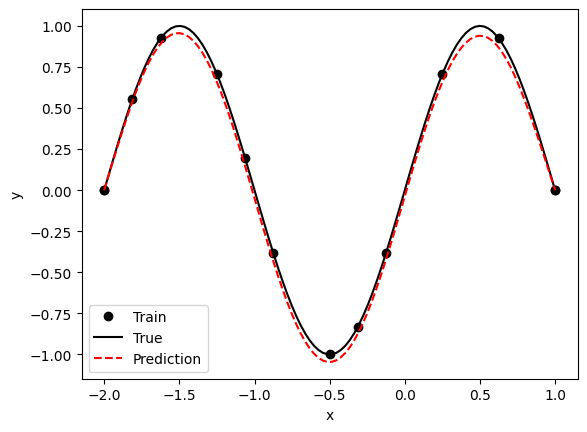

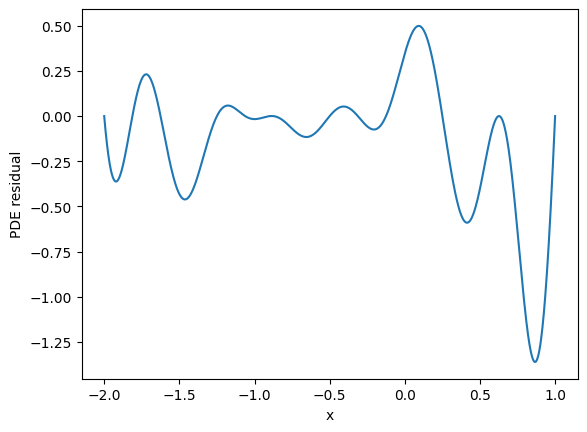

In [ ]:
"""Backend supported: tensorflow.compat.v1, tensorflow, pytorch, paddle"""
import deepxde as dde
import matplotlib.pyplot as plt
import numpy as np
# Import tf if using backend tensorflow.compat.v1 or tensorflow
from deepxde.backend import tf
# Import torch if using backend pytorch
# import torch
# Import paddle if using backend paddle
# import paddle


def pde(x, y):
    dy_xx = dde.grad.hessian(y, x)
    # Use tf.sin for backend tensorflow.compat.v1 or tensorflow
    return -dy_xx - np.pi ** 2 * tf.sin(np.pi * x)
    # Use torch.sin for backend pytorch
    # return -dy_xx - np.pi ** 2 * torch.sin(np.pi * x)
    # Use paddle.sin for backend paddle
    # return -dy_xx - np.pi ** 2 * paddle.sin(np.pi * x)


def boundary(x, on_boundary):
    return on_boundary


def func(x):
    return np.sin(np.pi * x)


geom = dde.geometry.Interval(-2, 1)
bc = dde.icbc.DirichletBC(geom, func, boundary)
data = dde.data.PDE(geom, pde, bc, 10, 2, solution=func, num_test=100)

layer_size = [1] + [50] * 3 + [1]
activation = "tanh"
initializer = "Glorot uniform"
net = dde.nn.FNN(layer_size, activation, initializer)

model = dde.Model(data, net)
model.compile("adam", lr=0.01, metrics=["l2 relative error"])

losshistory, train_state = model.train(iterations=10000)
# Optional: Save the model during training.
# checkpointer = dde.callbacks.ModelCheckpoint(
#     "model/model", verbose=1, save_better_only=True
# )
# Optional: Save the movie of the network solution during training.
# ImageMagick (https://imagemagick.org/) is required to generate the movie.
# movie = dde.callbacks.MovieDumper(
#     "model/movie", [-1], [1], period=100, save_spectrum=True, y_reference=func
# )
# losshistory, train_state = model.train(iterations=10000, callbacks=[checkpointer, movie])

dde.saveplot(losshistory, train_state, issave=True, isplot=True)

# Optional: Restore the saved model with the smallest training loss
# model.restore(f"model/model-{train_state.best_step}.ckpt", verbose=1)
# Plot PDE residual
x = geom.uniform_points(1000, True)
y = model.predict(x, operator=pde)
plt.figure()
plt.plot(x, y)
plt.xlabel("x")
plt.ylabel("PDE residual")
plt.show()

# (g) - Lotka-Volterra model

Compiling model...
Building feed-forward neural network...
'build' took 0.646337 s

'compile' took 5.928469 s

Training model...

0         [3.84e+02, 1.48e+00]    [3.84e+02, 1.48e+00]    []  
1000      [4.78e+00, 1.06e-01]    [4.65e+00, 1.02e-01]    []  

Best model at step 1000:
  train loss: 4.89e+00
  test loss: 4.75e+00
  test metric: []

'train' took 67.491358 s

Compiling model...
'compile' took 2.944275 s

Training model...

Step      Train loss              Test loss               Test metric
1000      [4.78e+00, 1.06e-01]    [4.65e+00, 1.02e-01]    []  
2000      [5.66e-02, 7.45e-02]    [5.66e-02, 7.45e-02]        
3000      [3.80e-02, 5.92e-02]    [3.80e-02, 5.92e-02]        
4000      [3.31e-02, 5.20e-02]    [3.31e-02, 5.20e-02]        
5000      [2.32e-02, 3.72e-02]    [2.32e-02, 3.72e-02]        
6000      [1.10e-02, 3.04e-02]    [1.10e-02, 3.04e-02]        
7000      [5.32e-03, 8.18e-03]    [5.32e-03, 8.18e-03]        
8000      [1.27e-03, 1.49e-03]    [1.27e-03, 1.49e-0

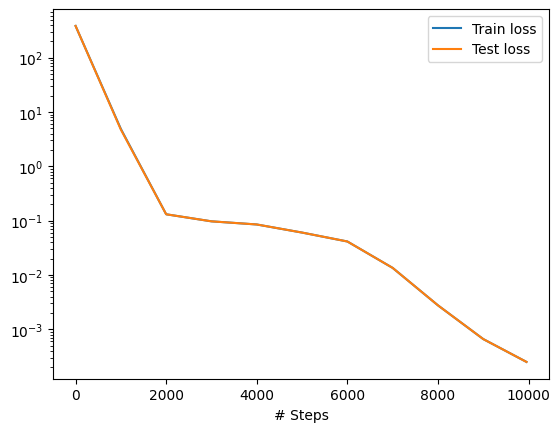

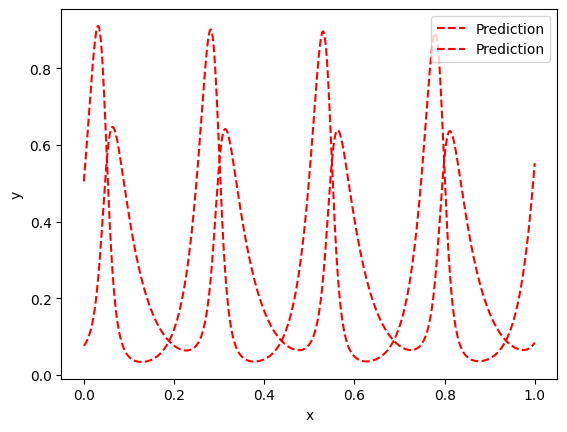

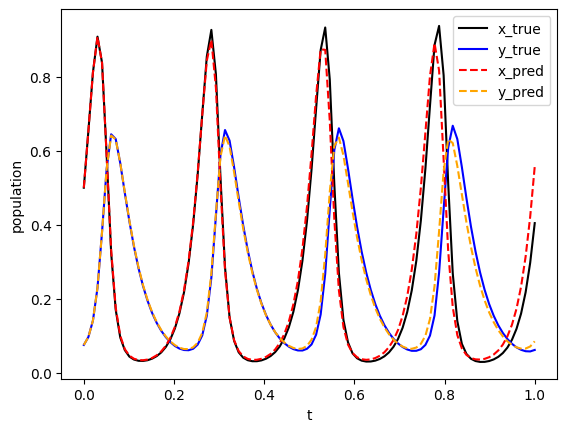

In [ ]:
"""Backend supported: tensorflow.compat.v1, tensorflow, pytorch, paddle, jax"""
import deepxde as dde
import matplotlib.pyplot as plt
import numpy as np
from scipy import integrate
# Import tf if using backend tensorflow.compat.v1 or tensorflow
from deepxde.backend import tf
# Import torch if using backend pytorch
# import torch
# Import paddle if using backend paddle
# import paddle
# Import jax.numpy if using backend jax
# import jax.numpy as jnp

ub = 200
rb = 20


def func(t, r):
    x, y = r
    dx_t = 1 / ub * rb * (2.0 * ub * x - 0.04 * ub * x * ub * y)
    dy_t = 1 / ub * rb * (0.02 * ub * x * ub * y - 1.06 * ub * y)
    return dx_t, dy_t


def gen_truedata():
    t = np.linspace(0, 1, 100)

    sol = integrate.solve_ivp(func, (0, 10), (100 / ub, 15 / ub), t_eval=t)
    x_true, y_true = sol.y
    x_true = x_true.reshape(100, 1)
    y_true = y_true.reshape(100, 1)

    return x_true, y_true


def ode_system(x, y):
    # Most backends
    r = y[:, 0:1]
    p = y[:, 1:2]
    dr_t = dde.grad.jacobian(y, x, i=0)
    dp_t = dde.grad.jacobian(y, x, i=1)
    # Backend jax
    # y_val, y_fn = y
    # r = y_val[:, 0:1]
    # p = y_val[:, 1:2]
    # dr_t, _ = dde.grad.jacobian(y, x, i=0)
    # dp_t, _ = dde.grad.jacobian(y, x, i=1)
    return [
        dr_t - 1 / ub * rb * (2.0 * ub * r - 0.04 * ub * r * ub * p),
        dp_t - 1 / ub * rb * (0.02 * r * ub * p * ub - 1.06 * p * ub),
    ]

geom = dde.geometry.TimeDomain(0, 1.0)
data = dde.data.PDE(geom, ode_system, [], 3000, 2, num_test=3000)

layer_size = [1] + [64] * 6 + [2]
activation = "tanh"
initializer = "Glorot normal"
net = dde.nn.FNN(layer_size, activation, initializer)

# Backend tensorflow.compat.v1 or tensorflow
def input_transform(t):
    return tf.concat(
        (
            t,
            tf.sin(t),
            tf.sin(2 * t),
            tf.sin(3 * t),
            tf.sin(4 * t),
            tf.sin(5 * t),
            tf.sin(6 * t),
        ),
        axis=1,
    )
# Backend pytorch
# def input_transform(t):
#     return torch.cat(
#         [
#             torch.sin(t),
#         ],
#         dim=1,
#     )
# Backend paddle
# def input_transform(t):
#     return paddle.concat(
#         (
#             paddle.sin(t),
#         ),
#         axis=1,
#     )
# Backend jax
# def input_transform(t):
#     if t.ndim == 1:
#         t = t[None]
#
#     return jnp.concatenate(
#         [
#             jnp.sin(t),
#         ],
#         axis=1
#     )

# hard constraints: x(0) = 100, y(0) = 15
# Backend tensorflow.compat.v1 or tensorflow
def output_transform(t, y):
    y1 = y[:, 0:1]
    y2 = y[:, 1:2]
    return tf.concat([y1 * tf.tanh(t) + 100 / ub, y2 * tf.tanh(t) + 15 / ub], axis=1)
# Backend pytorch
# def output_transform(t, y):
#     y1 = y[:, 0:1]
#     y2 = y[:, 1:2]
#     return torch.cat([y1 * torch.tanh(t) + 100 / ub, y2 * torch.tanh(t) + 15 / ub], dim=1)
# Backend paddle
# def output_transform(t, y):
#     y1 = y[:, 0:1]
#     y2 = y[:, 1:2]
#     return paddle.concat([y1 * paddle.tanh(t) + 100 / ub, y2 * paddle.tanh(t) + 15 / ub], axis=1)
# Backend jax
# def output_transform(t, y):
#     y1 = y[:, 0:1]
#     y2 = y[:, 1:2]
#     return jnp.concatenate(
#         [y1 * jnp.tanh(t) + 100 / ub, y2 * jnp.tanh(t) + 15 / ub],
#         axis=1
#     ).squeeze()

net.apply_feature_transform(input_transform)
net.apply_output_transform(output_transform)
model = dde.Model(data, net)

model.compile("adam", lr=0.001)
losshistory, train_state = model.train(iterations=1000)
# Most backends except jax can have a second fine tuning of the solution
model.compile("L-BFGS")
losshistory, train_state = model.train(iterations=1000)
dde.saveplot(losshistory, train_state, issave=True, isplot=True)

plt.xlabel("t")
plt.ylabel("population")

t = np.linspace(0, 1, 100)
x_true, y_true = gen_truedata()
plt.plot(t, x_true, color="black", label="x_true")
plt.plot(t, y_true, color="blue", label="y_true")

t = t.reshape(100, 1)
sol_pred = model.predict(t)
x_pred = sol_pred[:, 0:1]
y_pred = sol_pred[:, 1:2]

plt.plot(t, x_pred, color="red", linestyle="dashed", label="x_pred")
plt.plot(t, y_pred, color="orange", linestyle="dashed", label="y_pred")
plt.legend()
plt.show()

Compiling model...
Building feed-forward neural network...
'build' took 0.119324 s

'compile' took 3.512699 s

Training model...

Step      Train loss              Test loss               Test metric   
0         [4.31e+01, 2.72e-03]    [4.87e+01, 2.72e-03]    [9.63e-01]    
1000      [3.22e-04, 1.03e-07]    [6.31e-04, 1.03e-07]    [3.52e-04]    

Best model at step 1000:
  train loss: 3.22e-04
  test loss: 6.31e-04
  test metric: [3.52e-04]

'train' took 13.895386 s

Saving loss history to /content/loss.dat ...
Saving training data to /content/train.dat ...
Saving test data to /content/test.dat ...


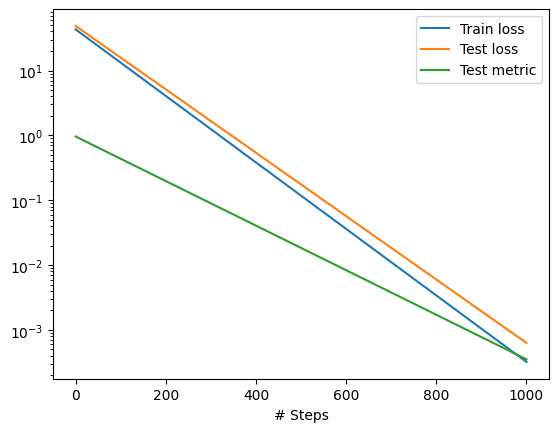

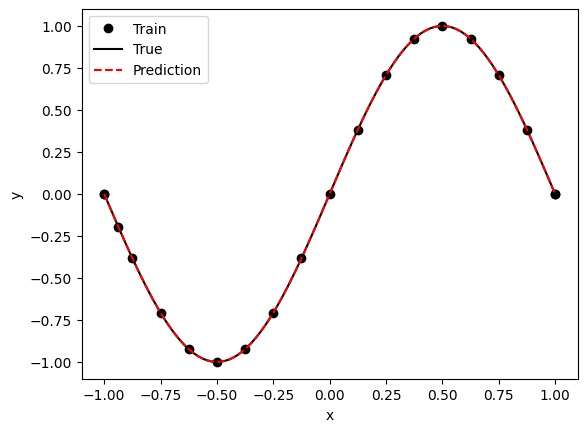

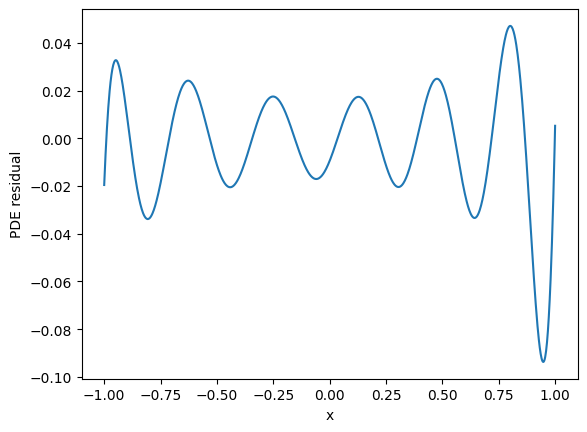

In [ ]:
"""Backend supported: tensorflow.compat.v1, tensorflow, pytorch, paddle"""
import deepxde as dde
import matplotlib.pyplot as plt
import numpy as np
# Import tf if using backend tensorflow.compat.v1 or tensorflow
from deepxde.backend import tf
# Import torch if using backend pytorch
# import torch
# Import paddle if using backend paddle
# import paddle


def pde(x, y):
    dy_xx = dde.grad.hessian(y, x)
    # Use tf.sin for backend tensorflow.compat.v1 or tensorflow
    return -dy_xx - np.pi ** 2 * tf.sin(np.pi * x)
    # Use torch.sin for backend pytorch
    # return -dy_xx - np.pi ** 2 * torch.sin(np.pi * x)
    # Use paddle.sin for backend paddle
    # return -dy_xx - np.pi ** 2 * paddle.sin(np.pi * x)


def boundary(x, on_boundary):
    return on_boundary


def func(x):
    return np.sin(np.pi * x)


geom = dde.geometry.Interval(-1, 1)
bc = dde.icbc.DirichletBC(geom, func, boundary)
data = dde.data.PDE(geom, pde, bc, 16, 2, solution=func, num_test=100)

layer_size = [1] + [50] * 3 + [1]
activation = "tanh"
initializer = "Glorot uniform"
net = dde.nn.FNN(layer_size, activation, initializer)

model = dde.Model(data, net)
model.compile("adam", lr=0.001, metrics=["l2 relative error"])

losshistory, train_state = model.train(iterations=1000)
# Optional: Save the model during training.
# checkpointer = dde.callbacks.ModelCheckpoint(
#     "model/model", verbose=1, save_better_only=True
# )
# Optional: Save the movie of the network solution during training.
# ImageMagick (https://imagemagick.org/) is required to generate the movie.
# movie = dde.callbacks.MovieDumper(
#     "model/movie", [-1], [1], period=100, save_spectrum=True, y_reference=func
# )
# losshistory, train_state = model.train(iterations=10000, callbacks=[checkpointer, movie])

dde.saveplot(losshistory, train_state, issave=True, isplot=True)

# Optional: Restore the saved model with the smallest training loss
# model.restore(f"model/model-{train_state.best_step}.ckpt", verbose=1)
# Plot PDE residual
x = geom.uniform_points(1000, True)
y = model.predict(x, operator=pde)
plt.figure()
plt.plot(x, y)
plt.xlabel("x")
plt.ylabel("PDE residual")
plt.show()

# 2D Helmholtz equation

Compiling model...
Building feed-forward neural network...
'build' took 0.116318 s

'compile' took 6.344177 s

Training model...

Step      Train loss    Test loss     Test metric   
0         [5.21e+03]    [6.44e+03]    [1.00e+00]    
1000      [3.69e+01]    [4.44e+01]    [2.55e-01]    
2000      [1.15e+00]    [1.27e+00]    [4.04e-02]    
3000      [9.08e-02]    [9.04e-02]    [4.80e-03]    
4000      [1.04e+01]    [1.09e+01]    [5.04e-02]    
5000      [2.90e-01]    [3.16e-01]    [8.06e-03]    

Best model at step 3000:
  train loss: 9.08e-02
  test loss: 9.04e-02
  test metric: [4.80e-03]

'train' took 193.685047 s

Saving loss history to /content/loss.dat ...
Saving training data to /content/train.dat ...
Saving test data to /content/test.dat ...


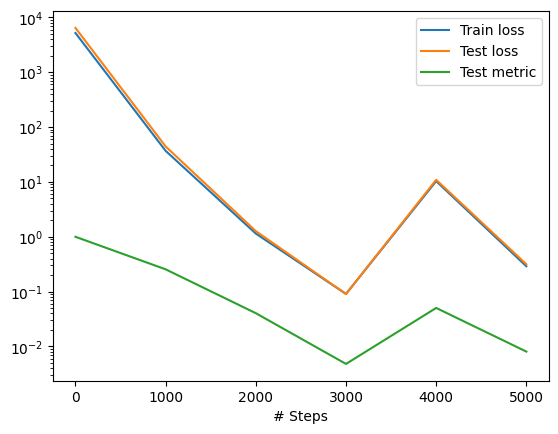

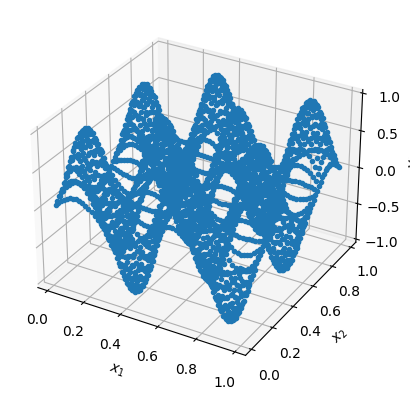

In [ ]:
"""Backend supported: tensorflow.compat.v1, tensorflow, pytorch, paddle"""
import deepxde as dde
import numpy as np

# General parameters
n = 2
precision_train = 10
precision_test = 30
hard_constraint = True
weights = 100  # if hard_constraint == False
iterations = 5000
parameters = [1e-3, 3, 150, "sin"]

# Define sine function
if dde.backend.backend_name == "pytorch":
    sin = dde.backend.pytorch.sin
elif dde.backend.backend_name == "paddle":
    sin = dde.backend.paddle.sin
else:
    from deepxde.backend import tf

    sin = tf.sin

learning_rate, num_dense_layers, num_dense_nodes, activation = parameters


def pde(x, y):
    dy_xx = dde.grad.hessian(y, x, i=0, j=0)
    dy_yy = dde.grad.hessian(y, x, i=1, j=1)

    f = k0 ** 2 * sin(k0 * x[:, 0:1]) * sin(k0 * x[:, 1:2])
    return -dy_xx - dy_yy - k0 ** 2 * y - f


def func(x):
    return np.sin(k0 * x[:, 0:1]) * np.sin(k0 * x[:, 1:2])


def transform(x, y):
    res = x[:, 0:1] * (1 - x[:, 0:1]) * x[:, 1:2] * (1 - x[:, 1:2])
    return res * y


def boundary(_, on_boundary):
    return on_boundary


geom = dde.geometry.Rectangle([0, 0], [1, 1])
k0 = 2 * np.pi * n
wave_len = 1 / n

hx_train = wave_len / precision_train
nx_train = int(1 / hx_train)

hx_test = wave_len / precision_test
nx_test = int(1 / hx_test)

if hard_constraint == True:
    bc = []
else:
    bc = dde.icbc.DirichletBC(geom, lambda x: 0, boundary)


data = dde.data.PDE(
    geom,
    pde,
    bc,
    num_domain=nx_train ** 2,
    num_boundary=4 * nx_train,
    solution=func,
    num_test=nx_test ** 2,
)

net = dde.nn.FNN(
    [2] + [num_dense_nodes] * num_dense_layers + [1], activation, "Glorot uniform"
)

if hard_constraint == True:
    net.apply_output_transform(transform)

model = dde.Model(data, net)

if hard_constraint == True:
    model.compile("adam", lr=learning_rate, metrics=["l2 relative error"])
else:
    loss_weights = [1, weights]
    model.compile(
        "adam",
        lr=learning_rate,
        metrics=["l2 relative error"],
        loss_weights=loss_weights,
    )


losshistory, train_state = model.train(iterations=iterations)
dde.saveplot(losshistory, train_state, issave=True, isplot=True)

# 2D Poisson

Compiling model...
Building feed-forward neural network...
'build' took 0.103683 s

'compile' took 1.462799 s

Training model...

Step      Train loss              Test loss               Test metric   
0         [1.05e-04, 2.78e-01]    [1.04e-04, 2.78e-01]    [2.47e+00]    
1000      [4.86e-06, 9.33e-06]    [3.80e-06, 9.33e-06]    [1.02e+00]    
2000      [6.26e-07, 2.17e-06]    [3.72e-07, 2.17e-06]    [1.02e+00]    
3000      [1.25e-07, 2.33e-07]    [8.36e-08, 2.33e-07]    [1.02e+00]    
4000      [9.60e-08, 7.27e-08]    [7.11e-08, 7.27e-08]    [1.03e+00]    
5000      [3.87e-07, 1.37e-04]    [3.79e-07, 1.37e-04]    [1.02e+00]    

Best model at step 4000:
  train loss: 1.69e-07
  test loss: 1.44e-07
  test metric: [1.03e+00]

'train' took 31.625459 s

Saving loss history to /content/loss.dat ...
Saving training data to /content/train.dat ...
Saving test data to /content/test.dat ...


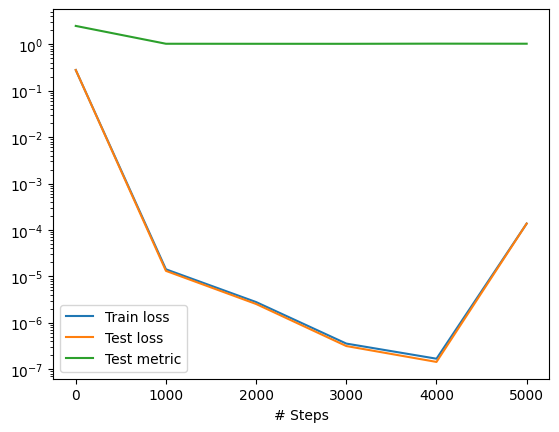

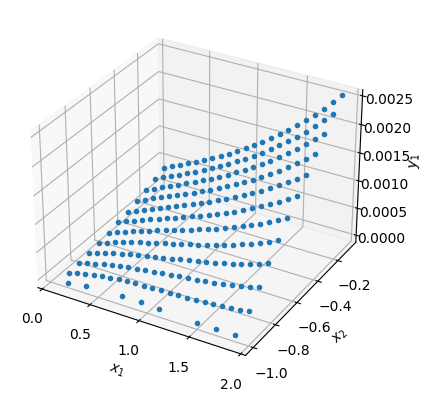

In [8]:
"""Backend supported: tensorflow.compat.v1, tensorflow, pytorch, paddle"""
import deepxde as dde
import numpy as np

# General parameters
L = 2 # wave/x length
h = 1 # depth
T = 1 # period
H = 0.05 # surface wave amplitude (I chose it arbitrarliy. Check p. 68 HRC)
c = L/T # wave propagation velocity (p. 70 HCR)
k = 2*np.pi/L # wave nr.
w = 2*np.pi/T

t = 0 # we are looking at a snapshot, so t is constant

precision_train = 10
precision_test = 30
hard_constraint = False
weights = 100  # if hard_constraint == False
iterations = 5000
parameters = [1e-3, 3, 150, "sin"]

# Define sine function
if dde.backend.backend_name == "pytorch":
    sin = dde.backend.pytorch.sin
elif dde.backend.backend_name == "paddle":
    sin = dde.backend.paddle.sin
else:
    from deepxde.backend import tf

    sin = tf.sin

learning_rate, num_dense_layers, num_dense_nodes, activation = parameters


def pde(x, y):
    dy_xx = dde.grad.hessian(y, x, i=0, j=0)
    dy_yy = dde.grad.hessian(y, x, i=1, j=1)

    return dy_xx + dy_yy


# Analytical solution (HRC p. 75)
def func(x):
    return -H*c/2 * np.cosh(k*(x[:, 1:2]+h))/np.sinh(k*h) * np.sin(w*t - k*x[:, 0:1])


def transform(x, y):
    res = x[:, 0:1] * (1 - x[:, 0:1]) * x[:, 1:2] * (1 - x[:, 1:2])
    return res * y


def boundary(_, on_boundary):
    return on_boundary

def boundary_bottom(x, on_boundary):
    return on_boundary and dde.utils.isclose(x[1],-h)

# Defining geometry
#geom = dde.geometry.Rectangle([0, 0], [1, 1])
geom = dde.geometry.Rectangle([0, -h], [L, 0])

# Defining random training and test collocation points
wave_len = L

hx_train = wave_len / precision_train
nx_train = int(1 / hx_train)

hx_test = wave_len / precision_test
nx_test = int(1 / hx_test)

# Transformation is applied if boundary constraints are applied in hard fashion
if hard_constraint == True:
    bc = []
else:
    bc = [dde.icbc.DirichletBC(geom, lambda x: 0, boundary_bottom, component=0)]

# Generate training and testing points
data = dde.data.PDE(
    geom,
    pde,
    bc,
    num_domain=nx_train ** 2,
    num_boundary=4 * nx_train,
    solution=func,
    num_test=nx_test ** 2,
)

# Choose network
net = dde.nn.FNN(
    [2] + [num_dense_nodes] * num_dense_layers + [1], activation, "Glorot uniform"
)

# Apply transform to enforce boundary conditions
if hard_constraint == True:
    net.apply_output_transform(transform)

# Build model
model = dde.Model(data, net)

if hard_constraint == True:
    model.compile("adam", lr=learning_rate, metrics=["l2 relative error"])
else:
    loss_weights = [1, weights]
    model.compile(
        "adam",
        lr=learning_rate,
        metrics=["l2 relative error"],
        loss_weights=loss_weights,
    )


losshistory, train_state = model.train(iterations=iterations)
dde.saveplot(losshistory, train_state, issave=True, isplot=True)